In [1]:
# If needed, install (uncomment and run once):
# !pip install -q "qiskit>=2.1" qiskit-aer

import math
import numpy as np
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector


In [21]:
plt.rcParams["font.family"] = "cmr10"
plt.rcParams["mathtext.fontset"] = "cm"
plt.rcParams["axes.grid"] = True
plt.rcParams["axes.formatter.use_mathtext"] = True

from qiskit.quantum_info import Statevector

def sv_from_circ(circ: QuantumCircuit) -> np.ndarray:
    sv = Statevector.from_instruction(circ)  # works for any number of qubits
    return np.asarray(sv, dtype=np.complex128)


class QubitSystem:
    def __init__(self, statevector: np.ndarray, label: str = "Qubit System"):
        self.label = label
        self.set_statevector(statevector)

    def set_statevector(self, statevector: np.ndarray):
        sv = np.asarray(statevector, dtype=np.complex128).flatten()
        if sv.ndim != 1:
            raise ValueError("Statevector must be 1D.")
        n_states = sv.size
        n_qubits = int(round(math.log2(n_states)))
        if 2**n_qubits != n_states:
            raise ValueError("Length must be a power of 2.")

        # Defensive normalization (harmless if already normalized)
        norm = np.linalg.norm(sv)
        if norm != 0 and not np.isclose(norm, 1.0):
            sv = sv / norm

        self.n_qubits = n_qubits
        self.n_states = n_states
        self.amps  = sv
        self.prob  = np.abs(sv)**2
        self.phase = np.angle(sv)

    def viz_circle(self, max_cols: int = 8, figsize_scale: float = 2.3):
        cols = max(1, min(max_cols, self.n_states))
        rows = int(math.ceil(self.n_states / cols))

        fig, axes = plt.subplots(
            rows, cols,
            figsize=(cols*figsize_scale, rows*(figsize_scale+0.2))
        )
        axes = np.atleast_2d(axes)

        def bitstr(i: int, n: int) -> str:
            return format(i, f"0{n}b")

        for idx in range(rows * cols):
            r, c = divmod(idx, cols)
            ax = axes[r, c]
            ax.set_aspect("equal")
            ax.set_xlim(0, 1); ax.set_ylim(0, 1)
            ax.axis("off")

            if idx >= self.n_states:
                ax.set_visible(False)
                continue

            # Outer reference circle
            ax.add_patch(plt.Circle((0.5, 0.5), 0.48, fill=False, lw=1.0, alpha=0.5))

            # Filled disk radius ∝ sqrt(probability) → area ∝ probability
            radius = 0.48 * np.sqrt(self.prob[idx])
            ax.add_patch(plt.Circle((0.5, 0.5), radius, alpha=0.25))

            # Phase arrow (angle in radians)
            angle = self.phase[idx]
            L = 0.45
            x2 = 0.5 + L * np.cos(angle)
            y2 = 0.5 + L * np.sin(angle)
            ax.arrow(0.5, 0.5, x2 - 0.5, y2 - 0.5,
                     head_width=0.03, head_length=0.05, length_includes_head=True)

            ax.set_title(rf"$|{bitstr(idx, self.n_qubits)}\rangle$", fontsize=10)


        fig.suptitle(self.label, fontsize=12)
        plt.tight_layout()
        plt.show()


In [25]:
def inc3_gate():
    """
    In-place increment by 1 modulo 8 on [q0 (LSB), q1, q2 (MSB)].
    Carry cascade via control-on-0 using the X-sandwich trick.
    """
    qc = QuantumCircuit(3, name="INC+1")
    # Flip q0
    qc.x(0)
    # Flip q1 iff q0 == 0
    qc.x(0); qc.cx(0, 1); qc.x(0)
    # Flip q2 iff q0 == 0 AND q1 == 0
    qc.x(0); qc.x(1); qc.ccx(0, 1, 2); qc.x(1); qc.x(0)
    return qc

def dec3_gate():
    """
    In-place decrement by 1 modulo 8 on [q0 (LSB), q1, q2 (MSB)].
    Borrow cascade with positive controls.
    """
    qc = QuantumCircuit(3, name="DEC-1")
    qc.x(0)           # flip q0
    qc.cx(0, 1)       # flip q1 iff q0 == 1
    qc.ccx(0, 1, 2)   # flip q2 iff q0 == 1 and q1 == 1
    return qc

inc = inc3_gate()
dec = dec3_gate()


C:\Users\angry\AppData\Local\Temp\ipykernel_13532\2923274716.py:79: UserWarning: Glyph 10217 (\N{MATHEMATICAL RIGHT ANGLE BRACKET}) missing from font(s) cmr10.
  plt.tight_layout()
C:\Users\angry\AppData\Local\Temp\ipykernel_13532\2923274716.py:79: UserWarning: Glyph 8730 (\N{SQUARE ROOT}) missing from font(s) cmr10.
  plt.tight_layout()


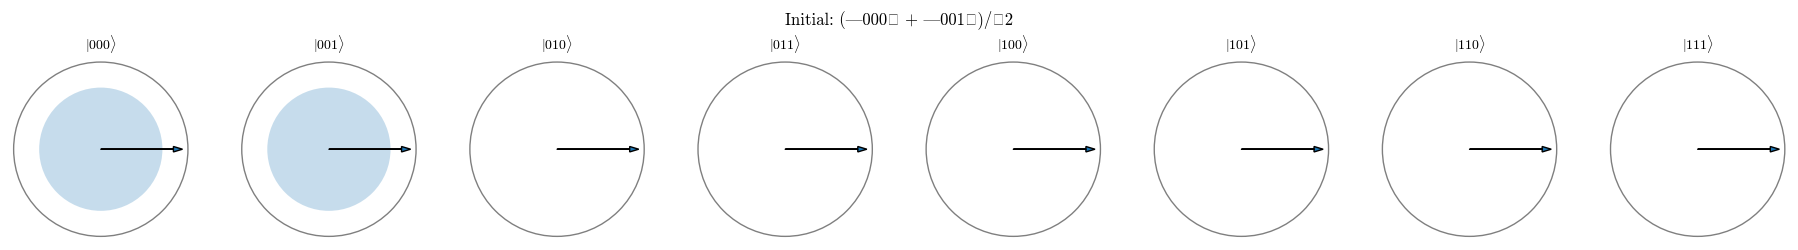

In [27]:
# Choose a superposition that visibly moves under +=1 / -=1.
# We'll use H on the LSB only: (|000⟩ + |001⟩) / √2
prep = QuantumCircuit(3, name="prep (H on LSB)")
prep.h(0)

sv_init = sv_from_circ(prep)
QubitSystem(sv_init, label="Initial: (|000⟩ + |001⟩)/√2").viz_circle()


C:\Users\angry\AppData\Local\Temp\ipykernel_13532\2923274716.py:79: UserWarning: Glyph 10217 (\N{MATHEMATICAL RIGHT ANGLE BRACKET}) missing from font(s) cmr10.
  plt.tight_layout()
C:\Users\angry\AppData\Local\Temp\ipykernel_13532\2923274716.py:79: UserWarning: Glyph 8730 (\N{SQUARE ROOT}) missing from font(s) cmr10.
  plt.tight_layout()


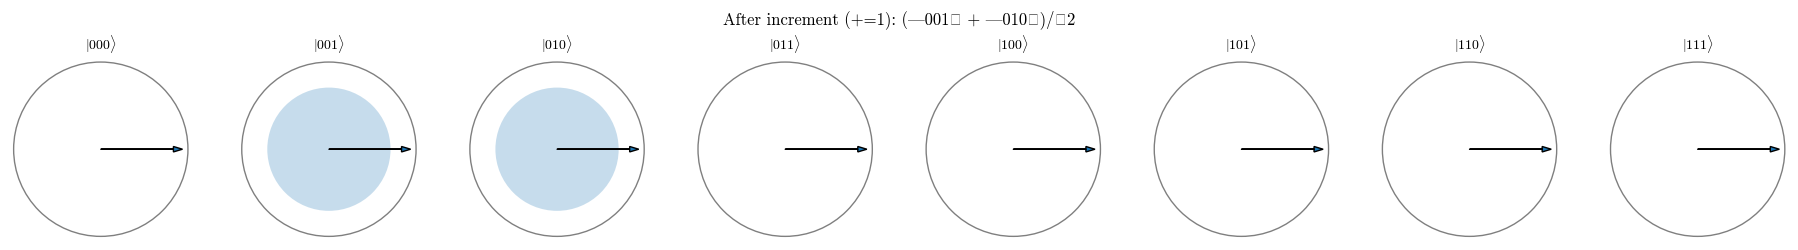

In [28]:
circ_inc = prep.compose(inc)
sv_after_inc = sv_from_circ(circ_inc)
QubitSystem(sv_after_inc, label="After increment (+=1): (|001⟩ + |010⟩)/√2").viz_circle()


C:\Users\angry\AppData\Local\Temp\ipykernel_13532\2923274716.py:79: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) cmr10.
  plt.tight_layout()


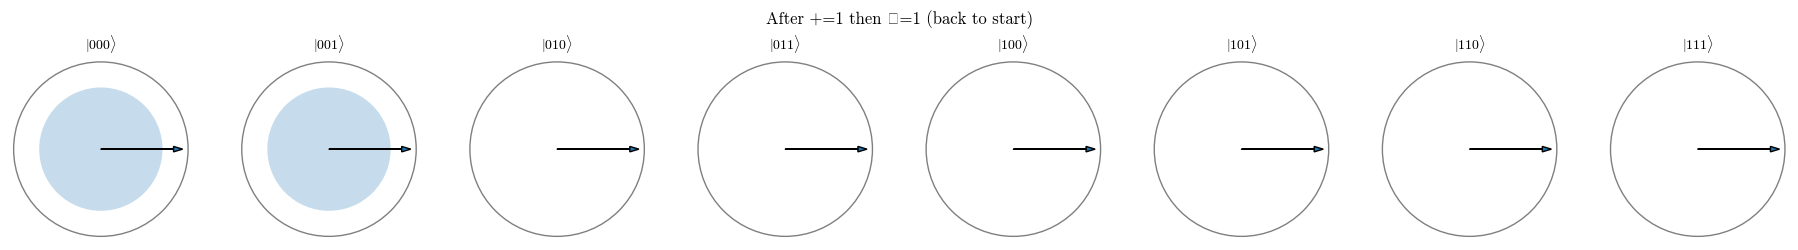

In [29]:
circ_dec_after_inc = circ_inc.compose(dec)  # +=1 then −=1 (net: identity)
sv_after_inc_dec = sv_from_circ(circ_dec_after_inc)
QubitSystem(sv_after_inc_dec, label="After +=1 then −=1 (back to start)").viz_circle()


In [30]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector
import numpy as np

# Two's complement interpretation on 3 bits: range [-4, +3]
def signed_value(bits3: int) -> int:
    return bits3 - 8 if (bits3 & 0b100) else bits3

# Make a circuit that prepares a given 3-bit basis state |b2 b1 b0⟩
def bits_to_circ(x: int) -> QuantumCircuit:
    qc = QuantumCircuit(3)
    if x & 1: qc.x(0)
    if x & 2: qc.x(1)
    if x & 4: qc.x(2)
    return qc

# Print the basis index before/after a circuit, both unsigned and signed
def show_before_after(label, prep_circ: QuantumCircuit, op_circ: QuantumCircuit = None):
    sv_in = Statevector.from_instruction(prep_circ).data
    i_in  = int(np.argmax(np.abs(sv_in)))
    text = [f"{label} — BEFORE: bits={i_in:03b}, unsigned={i_in}, signed={signed_value(i_in)}"]
    if op_circ is not None:
        sv_out = Statevector.from_instruction(prep_circ.compose(op_circ)).data
        i_out  = int(np.argmax(np.abs(sv_out)))
        text += [f"{label} — AFTER:  bits={i_out:03b}, unsigned={i_out}, signed={signed_value(i_out)}"]
    print("\n".join(text))


C:\Users\angry\AppData\Local\Temp\ipykernel_13532\2923274716.py:79: UserWarning: Glyph 10217 (\N{MATHEMATICAL RIGHT ANGLE BRACKET}) missing from font(s) cmr10.
  plt.tight_layout()


Overflow (INC) — BEFORE: bits=111, unsigned=7, signed=-1
Overflow (INC) — AFTER:  bits=000, unsigned=0, signed=0


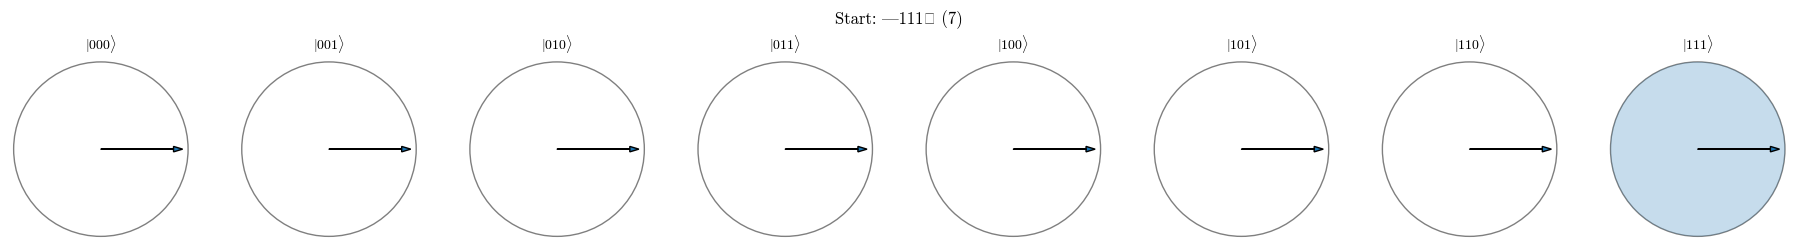

C:\Users\angry\AppData\Local\Temp\ipykernel_13532\2923274716.py:79: UserWarning: Glyph 8594 (\N{RIGHTWARDS ARROW}) missing from font(s) cmr10.
  plt.tight_layout()


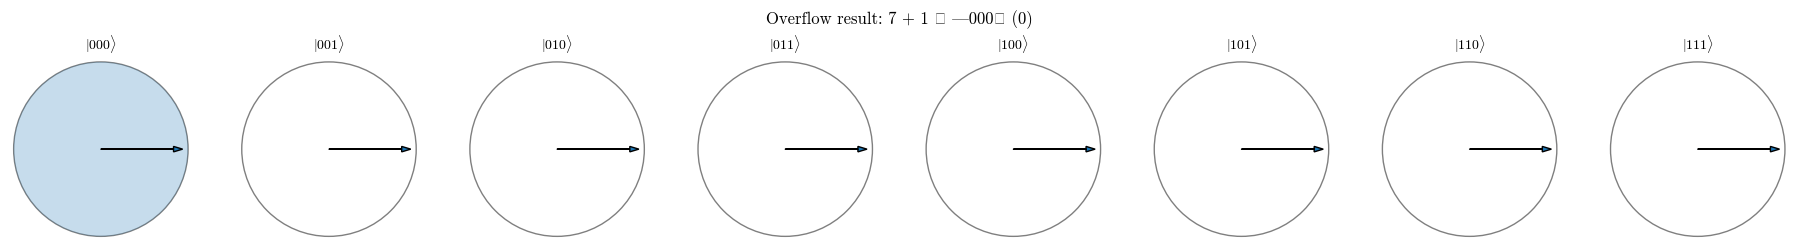

In [31]:
# Uses the INC circuit from Task 1.1 (variable 'inc')
prep_7 = bits_to_circ(0b111)   # |111⟩ (7)
show_before_after("Overflow (INC)", prep_7, inc)

# Optional circle plots if QubitSystem is available:
try:
    QubitSystem(sv_from_circ(prep_7), "Start: |111⟩ (7)").viz_circle()
    QubitSystem(sv_from_circ(prep_7.compose(inc)), "Overflow result: 7 + 1 → |000⟩ (0)").viz_circle()
except NameError:
    pass


C:\Users\angry\AppData\Local\Temp\ipykernel_13532\2923274716.py:79: UserWarning: Glyph 10217 (\N{MATHEMATICAL RIGHT ANGLE BRACKET}) missing from font(s) cmr10.
  plt.tight_layout()


Underflow (DEC) — BEFORE: bits=000, unsigned=0, signed=0
Underflow (DEC) — AFTER:  bits=111, unsigned=7, signed=-1


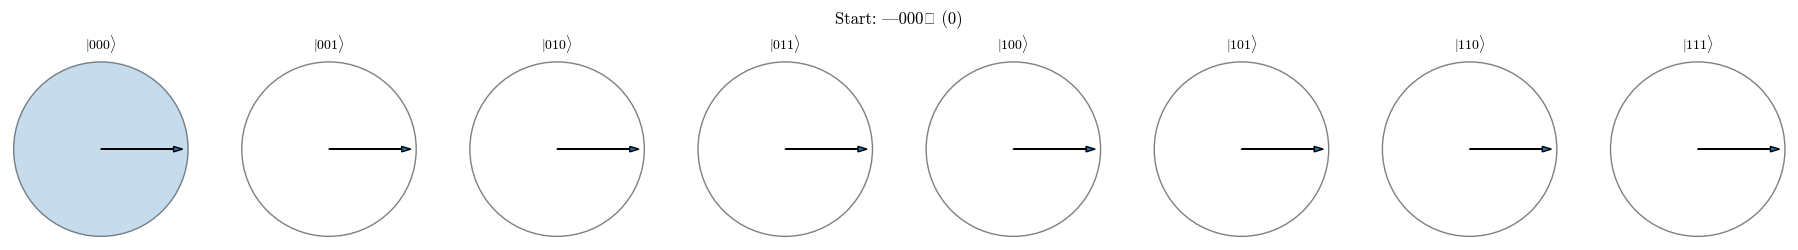

C:\Users\angry\AppData\Local\Temp\ipykernel_13532\2923274716.py:79: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) cmr10.
  plt.tight_layout()
C:\Users\angry\AppData\Local\Temp\ipykernel_13532\2923274716.py:79: UserWarning: Glyph 8594 (\N{RIGHTWARDS ARROW}) missing from font(s) cmr10.
  plt.tight_layout()


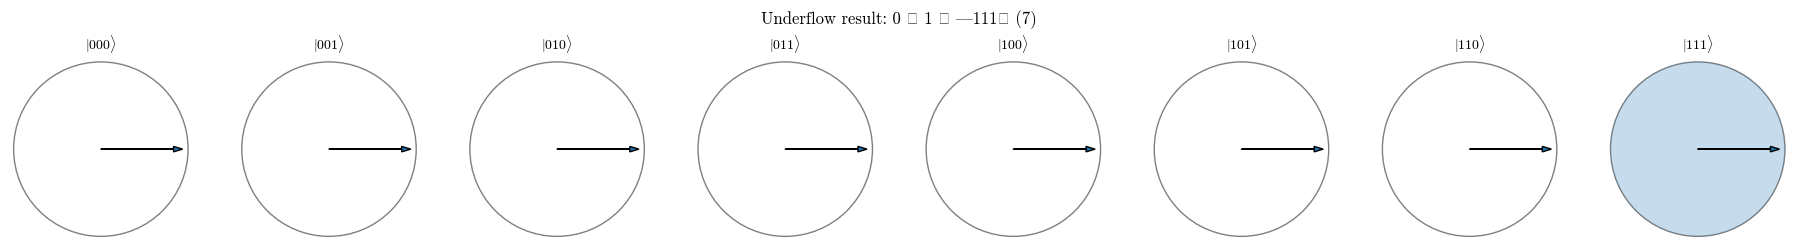

In [32]:
# Uses the DEC circuit from Task 1.1 (variable 'dec')
prep_0 = bits_to_circ(0b000)   # |000⟩ (0)
show_before_after("Underflow (DEC)", prep_0, dec)

# Optional circle plots
try:
    QubitSystem(sv_from_circ(prep_0), "Start: |000⟩ (0)").viz_circle()
    QubitSystem(sv_from_circ(prep_0.compose(dec)), "Underflow result: 0 − 1 → |111⟩ (7)").viz_circle()
except NameError:
    pass


C:\Users\angry\AppData\Local\Temp\ipykernel_13532\2923274716.py:79: UserWarning: Glyph 10217 (\N{MATHEMATICAL RIGHT ANGLE BRACKET}) missing from font(s) cmr10.
  plt.tight_layout()
C:\Users\angry\AppData\Local\Temp\ipykernel_13532\2923274716.py:79: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) cmr10.
  plt.tight_layout()


Signed example (−1 + 1) — BEFORE: bits=111, unsigned=7, signed=-1
Signed example (−1 + 1) — AFTER:  bits=000, unsigned=0, signed=0
Signed example (−4 − 1) — BEFORE: bits=100, unsigned=4, signed=-4
Signed example (−4 − 1) — AFTER:  bits=011, unsigned=3, signed=3


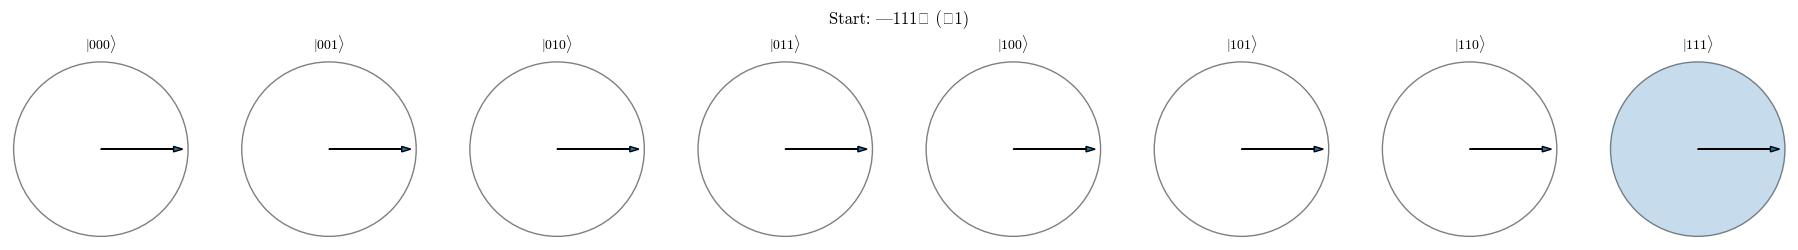

C:\Users\angry\AppData\Local\Temp\ipykernel_13532\2923274716.py:79: UserWarning: Glyph 8594 (\N{RIGHTWARDS ARROW}) missing from font(s) cmr10.
  plt.tight_layout()


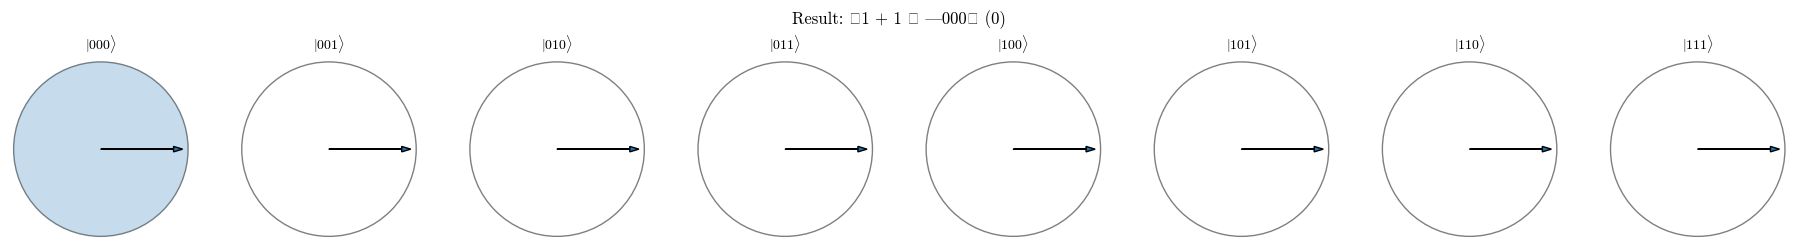

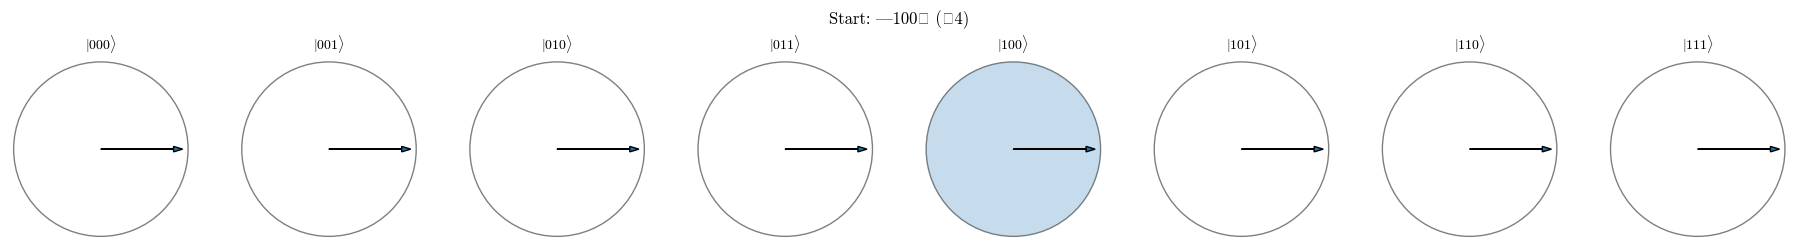

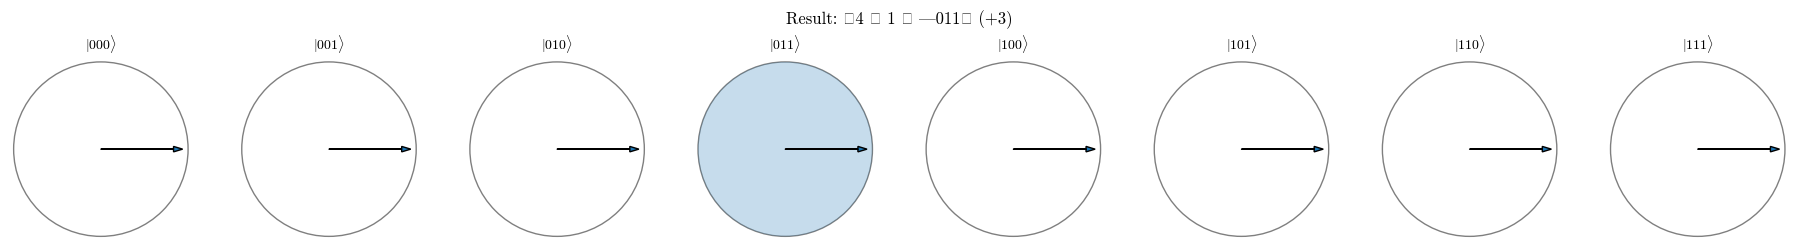

In [33]:
# Example 1: start at −1 (111), increment → 0 (000)
prep_neg1 = bits_to_circ(0b111)
show_before_after("Signed example (−1 + 1)", prep_neg1, inc)

# Example 2: start at −4 (100), decrement → +3 (011)
prep_neg4 = bits_to_circ(0b100)
show_before_after("Signed example (−4 − 1)", prep_neg4, dec)

# Optional circle plots
try:
    QubitSystem(sv_from_circ(prep_neg1), "Start: |111⟩ (−1)").viz_circle()
    QubitSystem(sv_from_circ(prep_neg1.compose(inc)), "Result: −1 + 1 → |000⟩ (0)").viz_circle()

    QubitSystem(sv_from_circ(prep_neg4), "Start: |100⟩ (−4)").viz_circle()
    QubitSystem(sv_from_circ(prep_neg4.compose(dec)), "Result: −4 − 1 → |011⟩ (+3)").viz_circle()
except NameError:
    pass


In [ ]:
import numpy as np
from qiskit import QuantumCircuit

def qft4_dagger(no_swaps: bool = True) -> QuantumCircuit:
    """
    4-qubit QFT† (inverse QFT) in the 'figure style':
      - Controlled phases use NEGATIVE angles: −π/2, −π/4, −π/8
      - For each target qubit: apply CPs first, THEN H on that target
      - Optional final bit-reversal swaps (q0<->q3, q1<->q2)
    Wires (Qiskit little-endian): q0 (LSB) ... q3 (MSB)
    """
    qc = QuantumCircuit(4, name="QFT† (figure-style)")

    # Column 1: target q3 gets CP from q2,q1,q0, then H(q3)
    qc.h(3)
    qc.cp(-np.pi/2, 2, 3)   # control q2 -> target q3
    qc.cp(-np.pi/4, 1, 3)   # control q1 -> target q3
    qc.cp(-np.pi/8, 0, 3)   # control q0 -> target q3

    # Column 2: target q2 gets CP from q1,q0, then H(q2)
    qc.h(2)
    qc.cp(-np.pi/2, 1, 2)   # control q1 -> target q2
    qc.cp(-np.pi/4, 0, 2)   # control q0 -> target q2

    # Column 3: target q1 gets CP from q0, then H(q1)
    qc.h(1)
    qc.cp(-np.pi/2, 0, 1)   # control q0 -> target q1

    # Column 4: only H(q0)
    qc.h(0)

    # Final bit-reversal swaps (as drawn)
    qc.swap(0, 3)
    # qc.swap(1, 2)

    return qc


def qft4(no_swaps: bool = True) -> QuantumCircuit:
    """
    Forward QFT — just the inverse of QFT† above.
    (Positive-angle, H-then-CP equivalent up to ordering.)
    """
    return qft4_dagger(no_swaps=no_swaps).inverse()


def iqft4(no_swaps: bool = True) -> QuantumCircuit:
    Inverse QFT (i.e., QFT†). For convenience, expose it directly.
    """
    return qft4_dagger(no_swaps=no_swaps)



In [ ]:
def basis_4q(k: int) -> QuantumCircuit:
    """Prepare |k> on 4 qubits (little-endian)."""
    qc = QuantumCircuit(4, name=f"|{k:04b}⟩")
    if k & 1: qc.x(0)
    if k & 2: qc.x(1)
    if k & 4: qc.x(2)
    if k & 8: qc.x(3)
    return qc

k = 3  # choose frequency 0..15
prep_k = basis_4q(k)
prep_signal = prep_k.compose(iqft4(no_swaps=True))  # produces phase-ramp (complex sinusoid)


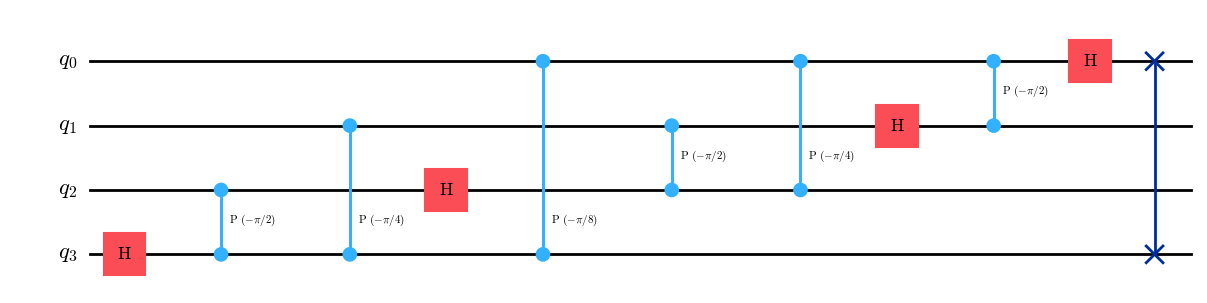

In [ ]:
prep_signal.decompose().draw("mpl")
qft4_dagger(no_swaps=True).draw("mpl")


PREP:
     ┌───┐         ░ 
q_0: ┤ H ├─────────░─
     ├───┤┌──────┐ ░ 
q_1: ┤ H ├┤ P(π) ├─░─
     ├───┤└──────┘ ░ 
q_2: ┤ H ├─────────░─
     ├───┤         ░ 
q_3: ┤ H ├─────────░─
     └───┘         ░ 

QFT† (figure-style):
                                         ░                           ░ »
q_0: ──────────────────────────■─────────░────────────■──────────────░─»
                               │         ░            │              ░ »
q_1: ────────────────■─────────┼─────────░──■─────────┼──────────────░─»
                     │         │         ░  │P(-π/2)  │P(-π/4) ┌───┐ ░ »
q_2: ──────■─────────┼─────────┼─────────░──■─────────■────────┤ H ├─░─»
     ┌───┐ │P(-π/2)  │P(-π/4)  │P(-π/8)  ░                     └───┘ ░ »
q_3: ┤ H ├─■─────────■─────────■─────────░───────────────────────────░─»
     └───┘                               ░                           ░ »
«                     ░ ┌───┐   
«q_0: ─■──────────────░─┤ H ├─X─
«      │P(-π/2) ┌───┐ ░ └───┘ │ 
«q_1: ─■────────┤ 

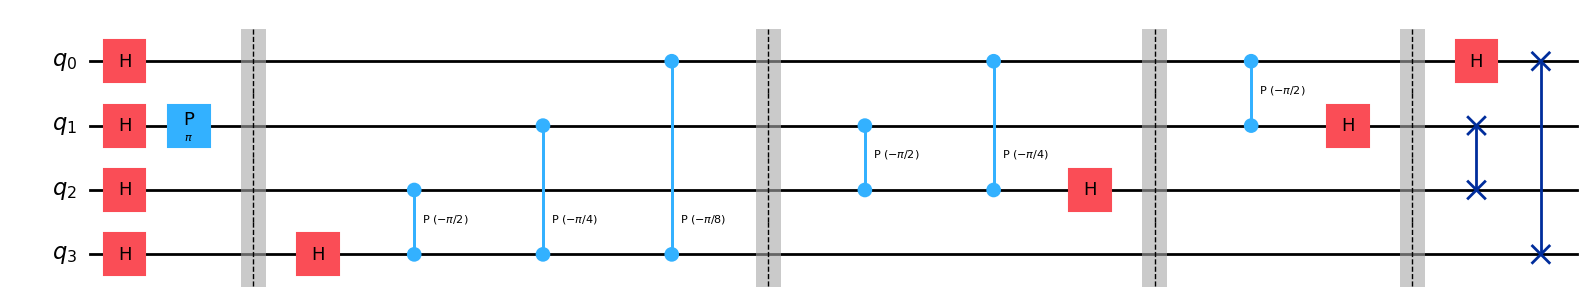

In [ ]:
import numpy as np
from qiskit import QuantumCircuit

def qft4() -> QuantumCircuit:
    qc = QuantumCircuit(4)

    qc.h(3)
    qc.cp(-np.pi/2, 2, 3)
    qc.cp(-np.pi/4, 1, 3)
    qc.cp(-np.pi/8, 0, 3)
    qc.barrier()

    qc.cp(-np.pi/2, 1, 2)
    qc.cp(-np.pi/4, 0, 2)
    qc.h(2)
    qc.barrier()

    qc.cp(-np.pi/2, 0, 1)
    qc.h(1)
    qc.barrier()

    qc.h(0)

    qc.swap(0, 3)
    qc.swap(1, 2)

    return qc



def prep_from_slide() -> QuantumCircuit:
    qc = QuantumCircuit(4)
    qc.h(0); qc.h(1); qc.h(2); qc.h(3)
    qc.p(np.pi, 1) 
    qc.barrier()
    return qc

prep = prep_from_slide()
qft_dag = qft4()

full = prep.compose(qft_dag)

# Text drawings (portable)
print("PREP:")
print(prep.draw(output="text"))
print("\nQFT† (figure-style):")
print(qft_dag.draw(output="text"))
print("\nFULL (prep → QFT† with swaps):")
print(full.draw(output="text"))

# If matplotlib works in your env, these look closest to the slide:
prep.draw("mpl")
qft_dag.draw("mpl")
full.draw("mpl")


# TASK 2.2

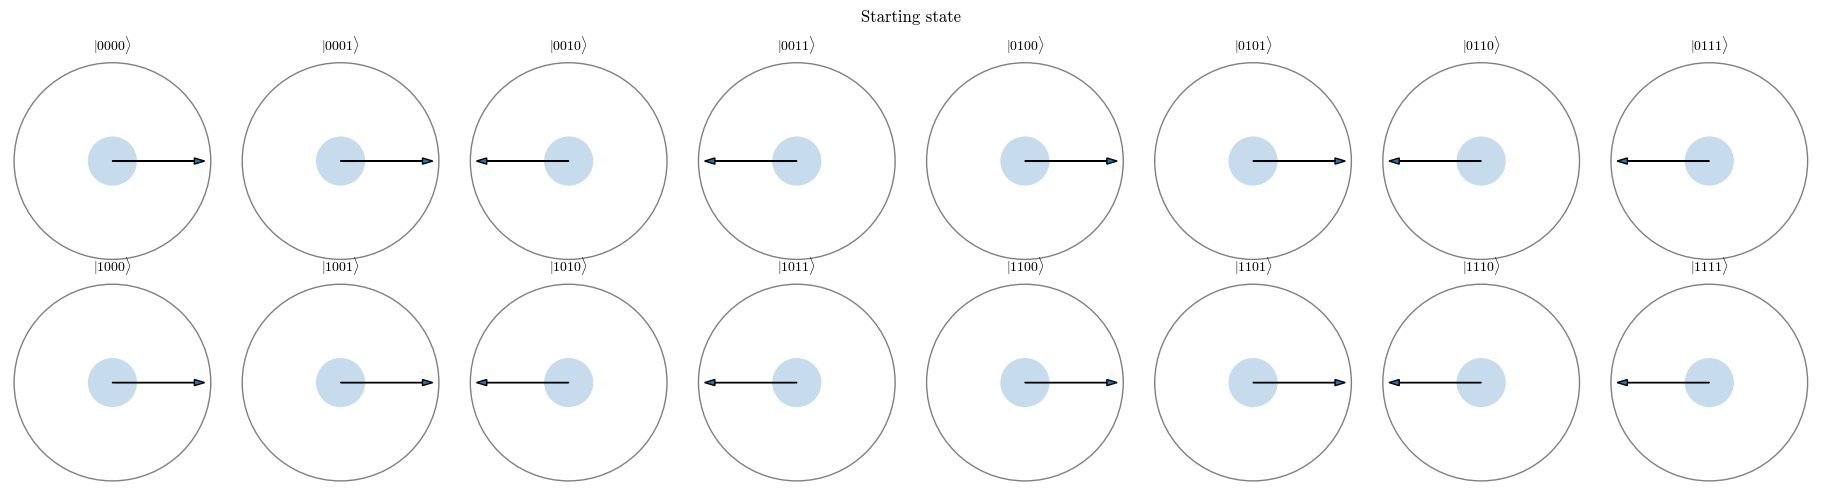

In [ ]:
signal_sv = sv_from_circ(prep)
QubitSystem(signal_sv, label="Preparation state").viz_circle()

/tmp/ipykernel_2061/2090947811.py:81: UserWarning: Glyph 8224 (\N{DAGGER}) missing from font(s) cmr10.
  plt.tight_layout()


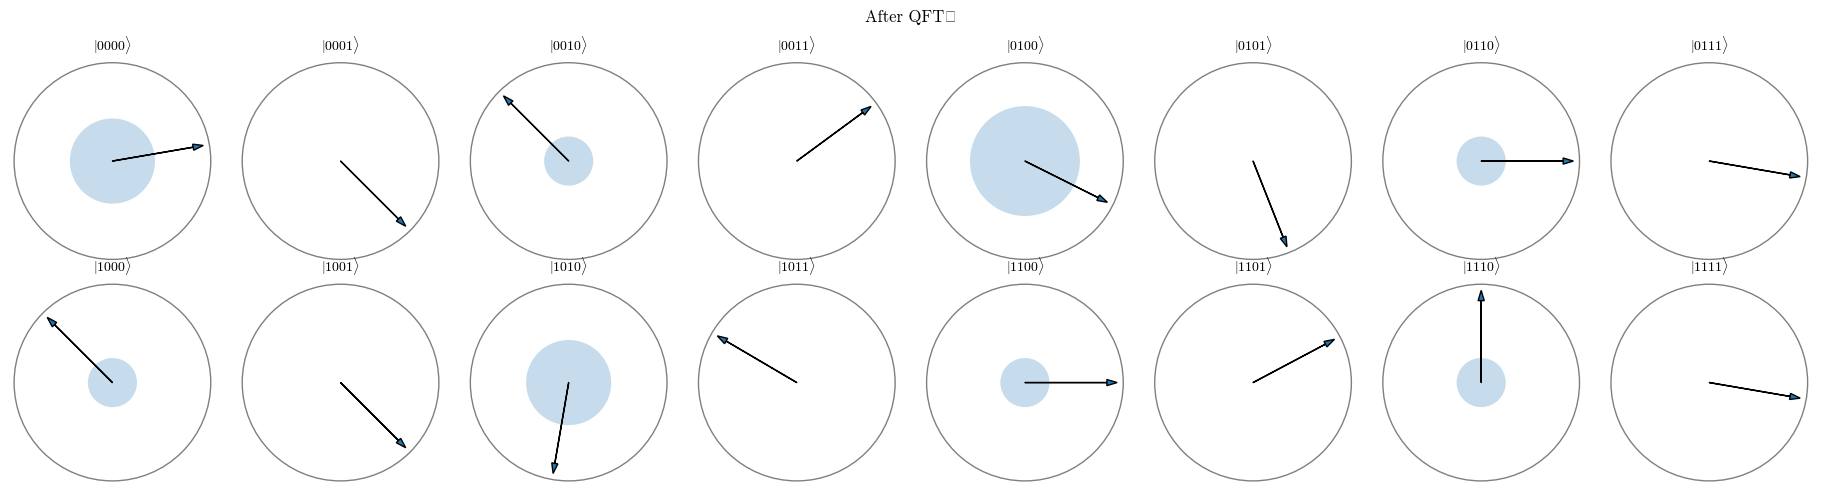

NameError: name 'sv_after_inc_dec' is not defined

In [ ]:
qft = qft4()
full_circ = prep.compose(qft) 

sv_after_qft = sv_from_circ(full_circ)

QubitSystem(sv_after_qft, label="After QFT†").viz_circle()

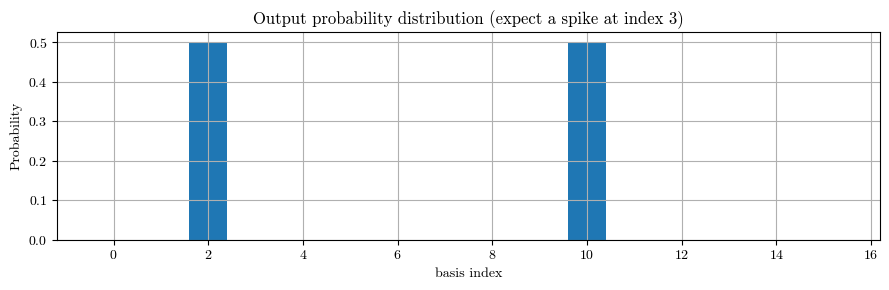

Top components: [(10, 0.49999999999999944), (2, 0.4999999999999993), (0, 3.930820526057307e-33), (4, 2.3801593248031538e-34), (14, 2.3801593248031538e-34)]


In [40]:
probs_out = np.abs(sv_out)**2
plt.figure(figsize=(9,3))
plt.bar(range(16), probs_out)
plt.title(f"Output probability distribution (expect a spike at index {k})")
plt.xlabel("basis index"); plt.ylabel("Probability"); plt.tight_layout(); plt.show()

print("Top components:", sorted([(i,float(p)) for i,p in enumerate(probs_out)], key=lambda t:-t[1])[:5])


In [41]:
import numpy as np
import math
import matplotlib.pyplot as plt

from qiskit import QuantumCircuit
from qiskit.quantum_info import Statevector

In [48]:
class QubitSystem:
    def __init__(self, statevector: np.ndarray, label: str = "Qubit System"):
        self.label = label; self.set_statevector(statevector)

    def set_statevector(self, statevector: np.ndarray):
        sv = np.asarray(statevector, dtype=np.complex128).flatten()
        n_states = sv.size; n_qubits = int(round(math.log2(n_states)))
        if 2**n_qubits != n_states:
            raise ValueError("Statevector length must be a power of 2.")
        norm = np.linalg.norm(sv)
        if norm != 0 and not np.isclose(norm, 1.0):
            sv = sv / norm
        self.n_qubits, self.n_states = n_qubits, n_states
        self.amps, self.prob, self.phase = sv, np.abs(sv)**2, np.angle(sv)

    def viz_circle(self, max_cols: int = 8, figsize_scale: float = 2.1):
        cols = max(1, min(max_cols, self.n_states))
        rows = int(math.ceil(self.n_states / cols))
        fig, axes = plt.subplots(rows, cols, figsize=(cols*figsize_scale, rows*(figsize_scale+0.2)))
        axes = np.atleast_2d(axes)

        def bitstr(i, n): return format(i, f"0{n}b")

        for idx in range(rows*cols):
            r,c = divmod(idx, cols)
            ax = axes[r,c]; ax.set_aspect("equal"); ax.set_xlim(0,1); ax.set_ylim(0,1); ax.axis("off")
            if idx >= self.n_states:
                ax.set_visible(False); continue

            # reference circle
            ax.add_patch(plt.Circle((0.5,0.5), 0.48, fill=False, lw=1.0, alpha=0.5))
            # area ∝ probability
            radius = 0.48*np.sqrt(self.prob[idx])
            ax.add_patch(plt.Circle((0.5,0.5), radius, alpha=0.25))
            # phase arrow
            angle = self.phase[idx]; L = 0.45
            x2 = 0.5 + L*np.cos(angle); y2 = 0.5 + L*np.sin(angle)
            ax.arrow(0.5,0.5, x2-0.5, y2-0.5, head_width=0.03, head_length=0.05, length_includes_head=True)
            # LaTeX ket label (compatible with rcParams above)
            ax.set_title(rf"$|{bitstr(idx, self.n_qubits)}\rangle$", fontsize=10)


        fig.suptitle(self.label, fontsize=12); plt.tight_layout(); plt.show()


In [ ]:
def qft4_dagger(no_swaps: bool = True) -> QuantumCircuit:
    """
    4-qubit QFT† in the slide 'figure style':
      - For each target: apply CPs with NEGATIVE angles (−π/2, −π/4, −π/8), THEN H(target)
      - If no_swaps == False, append final bit-reversal swaps (q0<->q3, q1<->q2)
    Wires (Qiskit little-endian): q0 (LSB) ... q3 (MSB)
    """
    qc = QuantumCircuit(4, name="QFT† (figure-style)")

    # target q3: controls q2, q1, q0 (CPs FIRST), then H
    qc.cp(-np.pi/2, 2, 3)
    qc.cp(-np.pi/4, 1, 3)
    qc.cp(-np.pi/8, 0, 3)
    qc.h(3)

    # target q2: controls q1, q0
    qc.cp(-np.pi/2, 1, 2)
    qc.cp(-np.pi/4, 0, 2)
    qc.h(2)

    # target q1: control q0
    qc.cp(-np.pi/2, 0, 1)
    qc.h(1)

    # target q0
    qc.h(0)

    # optional bit-reversal swaps
    if not no_swaps:
        qc.swap(0, 3)
        qc.swap(1, 2)

    return qc


def qft4(no_swaps: bool = True) -> QuantumCircuit:
    """Forward QFT consistent with qft4_dagger."""
    return qft4_dagger(no_swaps=no_swaps).inverse()


def iqft4(no_swaps: bool = True) -> QuantumCircuit:
    """Alias: inverse QFT (QFT†)."""
    return qft4_dagger(no_swaps=no_swaps)


In [56]:
def basis_4q(k: int) -> QuantumCircuit:
    """Prepare |k> on 4 qubits (little-endian)."""
    qc = QuantumCircuit(4, name=f"|{k:04b}⟩")
    if k & 1: qc.x(0)
    if k & 2: qc.x(1)
    if k & 4: qc.x(2)
    if k & 8: qc.x(3)
    return qc

# choose frequency 0..15
k = 3

# sinusoid in phase domain: invQFT(|k>) = QFT†(|k>)
prep_signal = basis_4q(k).compose(iqft4(no_swaps=True))  # no swaps inside the IQFT block


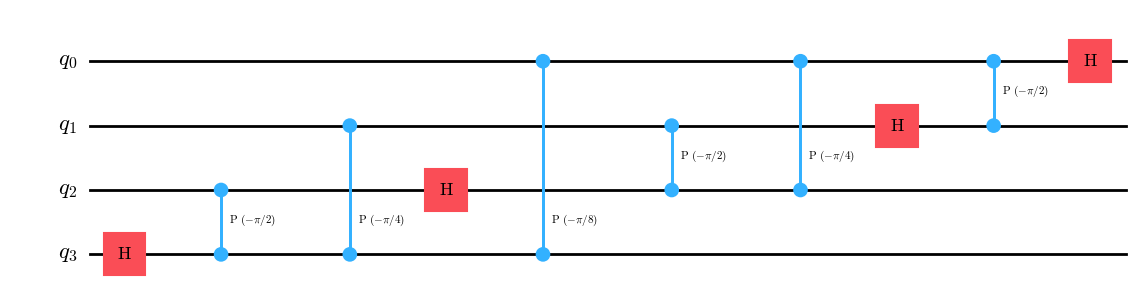

In [57]:
# Visual check of the blocks
prep_signal.decompose().draw("mpl")
iqft4(no_swaps=True).draw("mpl")


In [58]:
def prep_from_slide() -> QuantumCircuit:
    qc = QuantumCircuit(4, name="prep")
    qc.h(0); qc.h(1); qc.h(2); qc.h(3)
    qc.p(np.pi, 1)    # 180° on q1
    return qc

prep_slide = prep_from_slide()


C:\Users\angry\AppData\Local\Temp\ipykernel_13532\1571470663.py:43: UserWarning: Glyph 10217 (\N{MATHEMATICAL RIGHT ANGLE BRACKET}) missing from font(s) cmr10.
  fig.suptitle(self.label, fontsize=12); plt.tight_layout(); plt.show()


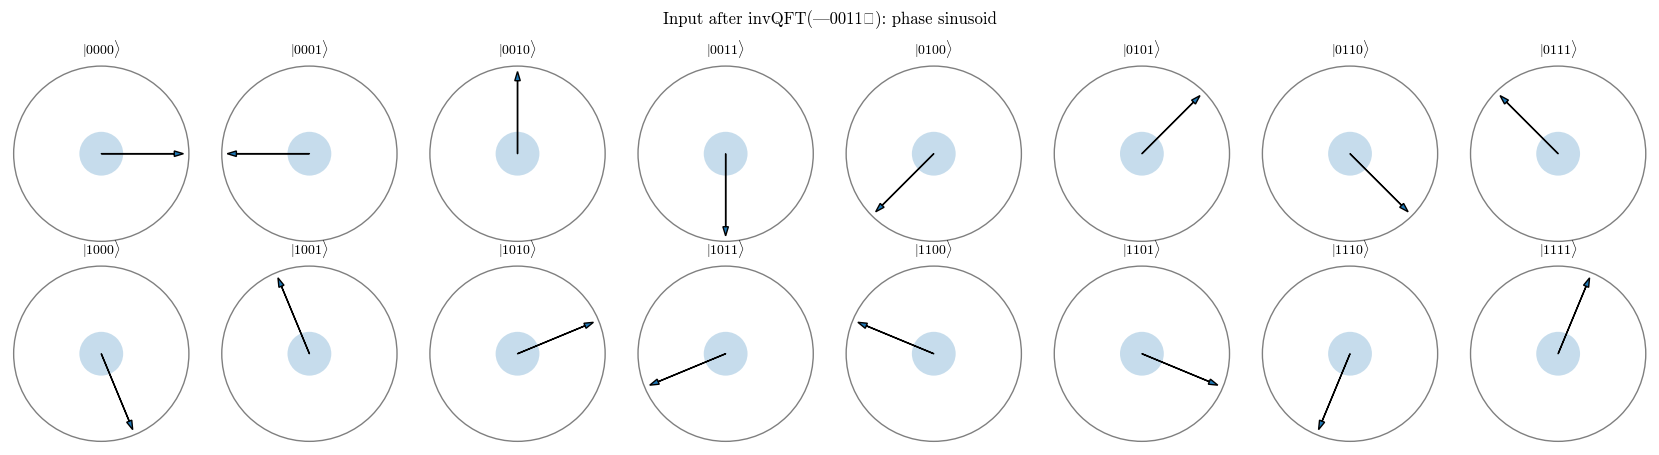

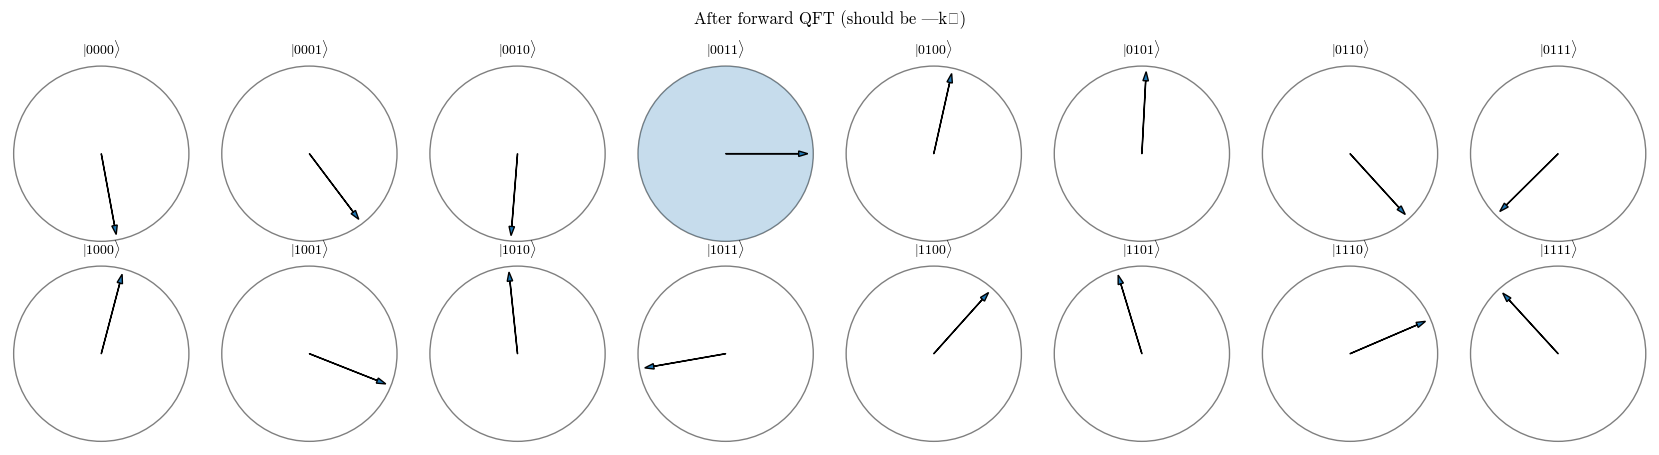

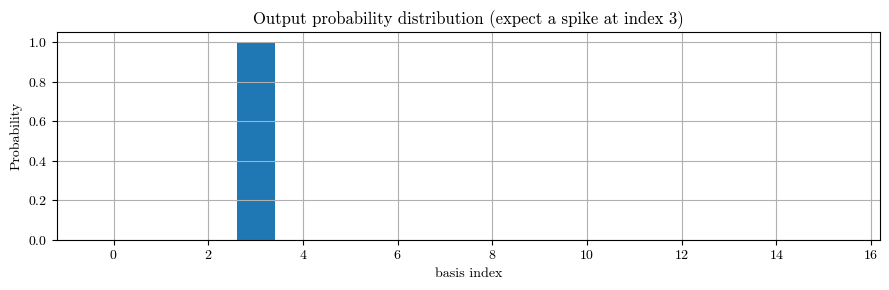

Top components: [(3, 0.9999999999999989), (11, 7.874234097671358e-33), (15, 4.9487276026143655e-33), (7, 9.186450602179643e-34), (9, 3.1856565270980963e-34)]


In [59]:
# Forward QFT (inverse of our QFT†)
qft_fwd = qft4(no_swaps=True)

# Full circuit: invQFT(|k>)  →  QFT = identity on |k>
full_signal = prep_signal.compose(qft_fwd)

# Statevectors
sv_in = np.asarray(Statevector(prep_signal), dtype=np.complex128)
sv_out = np.asarray(Statevector(full_signal), dtype=np.complex128)

# Circle plots
QubitSystem(sv_in,  label=f"Input after invQFT(|{k:04b}⟩): phase sinusoid").viz_circle(max_cols=8)
QubitSystem(sv_out, label="After forward QFT (should be |k⟩)").viz_circle(max_cols=8)

# Histogram & top components
probs_out = np.abs(sv_out)**2
plt.figure(figsize=(9,3))
plt.bar(range(16), probs_out)
plt.title(f"Output probability distribution (expect a spike at index {k})")
plt.xlabel("basis index"); plt.ylabel("Probability"); plt.tight_layout(); plt.show()

print("Top components:", sorted([(i, float(p)) for i, p in enumerate(probs_out)],
                               key=lambda t: -t[1])[:5])
